In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 8.11

In [2]:
prob_b = np.array([0.1, 0.9])
prob_f = np.array([0.1, 0.9])
prob_g_given_bf = np.array([[[0.9, 0.1], [0.8, 0.2]], [[0.8, 0.2], [0.2, 0.8]]])
prob_d_given_g = np.array([[0.9, 0.1], [0.1, 0.9]])

prob_bfgd = (
    1  #            [B, F, G, D]
    * prob_b.reshape(2, 1, 1, 1)
    * prob_f.reshape(1, 2, 1, 1)
    * prob_g_given_bf.reshape(2, 2, 2, 1)
    * prob_d_given_g.reshape(1, 1, 2, 2)
)

In [3]:
prob_fd = prob_bfgd.sum((0, 2), keepdims=True)
prob_f_given_d = prob_fd / prob_fd.sum(1, keepdims=True)
print(f"P(F=0 | D=0) = {prob_f_given_d[:, 0, :, 0].flat[0]:.2%}")

P(F=0 | D=0) = 21.25%


In [4]:
prob_bfd = prob_bfgd.sum(2, keepdims=True)
prob_f_given_bd = prob_bfd / prob_bfd.sum(1, keepdims=True)
print(f"P(F=0 | B=0, D=0) = {prob_f_given_bd[0, 0, :, 0].flat[0]:.2%}")

P(F=0 | B=0, D=0) = 10.96%


# Programming exercise

In [5]:
np.random.seed(0)


# I'm not sure if we're supposed to use the full loc-scale version of NumPy's generators,
# so here's a version using the math from the slides.
@np.vectorize(signature="(d),(d,d)->(r)")
def custom_multivariate_normal(mean: np.ndarray, a_transform: np.ndarray) -> np.ndarray:
    n_dim = a_transform.shape[1]
    e_noise = np.random.normal(0, 1, n_dim)
    return mean + a_transform @ e_noise


custom_multivariate_normal(np.array([0, 0]), np.identity(2))

array([1.76405235, 0.40015721])

In [6]:
test_x_vals = custom_multivariate_normal(np.zeros((20, 2)), np.diag((1, 1)) ** 0.5)
test_x_vals

array([[ 0.97873798,  2.2408932 ],
       [ 1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ],
       [ 0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502],
       [ 0.44386323,  0.33367433],
       [ 1.49407907, -0.20515826],
       [ 0.3130677 , -0.85409574],
       [-2.55298982,  0.6536186 ],
       [ 0.8644362 , -0.74216502],
       [ 2.26975462, -1.45436567],
       [ 0.04575852, -0.18718385],
       [ 1.53277921,  1.46935877],
       [ 0.15494743,  0.37816252],
       [-0.88778575, -1.98079647],
       [-0.34791215,  0.15634897],
       [ 1.23029068,  1.20237985],
       [-0.38732682, -0.30230275],
       [-1.04855297, -1.42001794]])

In [7]:
@np.vectorize
def custom_single_normal(mean: float, var: float) -> float:
    return np.random.normal(0, 1) * np.sqrt(var) + mean

In [8]:
np.random.seed(0)
test_theta = np.array([-1, 1]).reshape((2, 1))
test_y_means = test_x_vals @ test_theta
test_y_vals = custom_single_normal(test_y_means, 0.1)
test_y_vals

array([[ 1.38869604],
       [-2.53533174],
       [-0.39281298],
       [ 1.10439104],
       [ 1.00118754],
       [-0.33891837],
       [-0.15805226],
       [-1.731878  ],
       [-1.03732079],
       [ 3.25215899],
       [-1.14671956],
       [-3.48345904],
       [-0.19446535],
       [ 0.07694143],
       [ 0.32873218],
       [-0.62054143],
       [ 0.43938438],
       [ 0.07108987],
       [-0.18506472],
       [-1.17879124]])

In [9]:
def posterior_distribution_params(
    data: np.ndarray, targets: np.ndarray, target_variance: float
) -> tuple[np.ndarray, np.ndarray]:
    num, features = data.shape[:2]
    means = (
        data.T
        @ np.linalg.inv(target_variance * np.identity(num) + data @ data.T)
        @ targets
    ).flatten()
    covariance = (
        np.identity(features)
        - data.T
        @ np.linalg.inv(target_variance * np.identity(num) + data @ data.T)
        @ data
    )
    return means, covariance


test_post_mean, test_post_covar = posterior_distribution_params(
    test_x_vals, test_y_vals, 0.1
)
print(f"The posterior means are:\n{test_post_mean}")
print(f"The posterior covariance is:\n{test_post_covar}")

The posterior means are:
[-0.8759282   0.96717496]
The posterior covariance is:
[[ 0.00371136 -0.00025708]
 [-0.00025708  0.00451975]]


In [10]:
@np.vectorize(signature="(),(),(2),(2,2)->()")
def custom_2d_pdf(
    x0: float, x1: float, means: np.ndarray, covariance: np.ndarray
) -> float:
    difference = (np.array([x0, x1]) - means).reshape((-1, 1))
    d_dim = 2
    power = -0.5 * difference.T @ np.linalg.inv(covariance) @ difference
    exp_part = float(np.exp(power)[0, 0])
    normalize_part = (2 * np.pi) ** (d_dim / 2) * np.sqrt(np.linalg.det(covariance))
    return exp_part / normalize_part


custom_2d_pdf(-1, 1, test_post_mean, test_post_covar)

array(4.58522142)

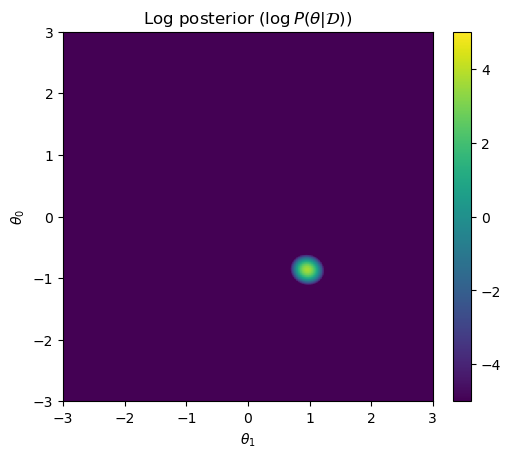

In [11]:
def plot_param_posterior(
    means: np.ndarray,
    covariance: np.ndarray,
    res: int = 200,
    extra_title: str = "",
    ax: plt.Axes = None,
):
    axis = np.linspace(-3, 3, axis=0, num=res).reshape((-1, 1))
    pdf = custom_2d_pdf(axis, axis.T, means.flatten(), covariance)
    pdf[pdf == 0] = 1e-10
    log_pdf = np.log(pdf)
    if ax is None:
        _, ax = plt.subplots()
    img = ax.imshow(log_pdf[::-1, :], vmin=-5, vmax=5)
    plt.colorbar(img, fraction=0.046, pad=0.04)
    img.set_extent((-3, 3, -3, 3))
    ax.autoscale(False)
    ax.set_ylabel(r"$\theta_0$")
    ax.set_xlabel(r"$\theta_1$")
    if extra_title:
        extra_title += ": "
    ax.set_title(extra_title + r"Log posterior ($\log P(\theta|\mathcal{D})$)")


plot_param_posterior(test_post_mean, test_post_covar)
plt.show()

In [12]:
@np.vectorize(signature="(),(),(),(2,2)->()")
def custom_2d_posterior_predictive_variance(
    x0: float, x1: float, target_var: float, post_covar: np.ndarray
) -> float:
    x_vec = np.array([x0, x1]).reshape((2, 1))
    return target_var + x_vec.T @ post_covar @ x_vec


custom_2d_posterior_predictive_variance(-1, 1, 0.1, test_post_covar)

array(0.10874527)

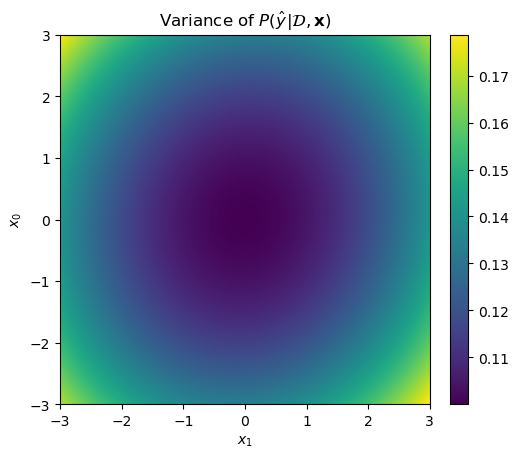

In [13]:
def plot_pp_var(
    target_var: float,
    post_covar: np.ndarray,
    res: int = 200,
    extra_title: str = "",
    ax=None,
):
    axis = np.linspace(-3, 3, axis=0, num=res).reshape((-1, 1))
    test_pdf = custom_2d_posterior_predictive_variance(
        axis, axis.T, target_var, post_covar
    )
    if ax is None:
        _, ax = plt.subplots()
    img = ax.imshow(test_pdf[::-1])
    plt.colorbar(img, fraction=0.046, pad=0.04)
    img.set_extent((-3, 3, -3, 3))
    ax.autoscale(False)
    ax.set_ylabel(r"$x_0$")
    ax.set_xlabel(r"$x_1$")
    if extra_title:
        extra_title += ": "
    ax.set_title(extra_title + r"Variance of $P(\hat y|\mathcal{D}, \mathbf{x})$")


plot_pp_var(0.1, test_post_covar)
plt.show()

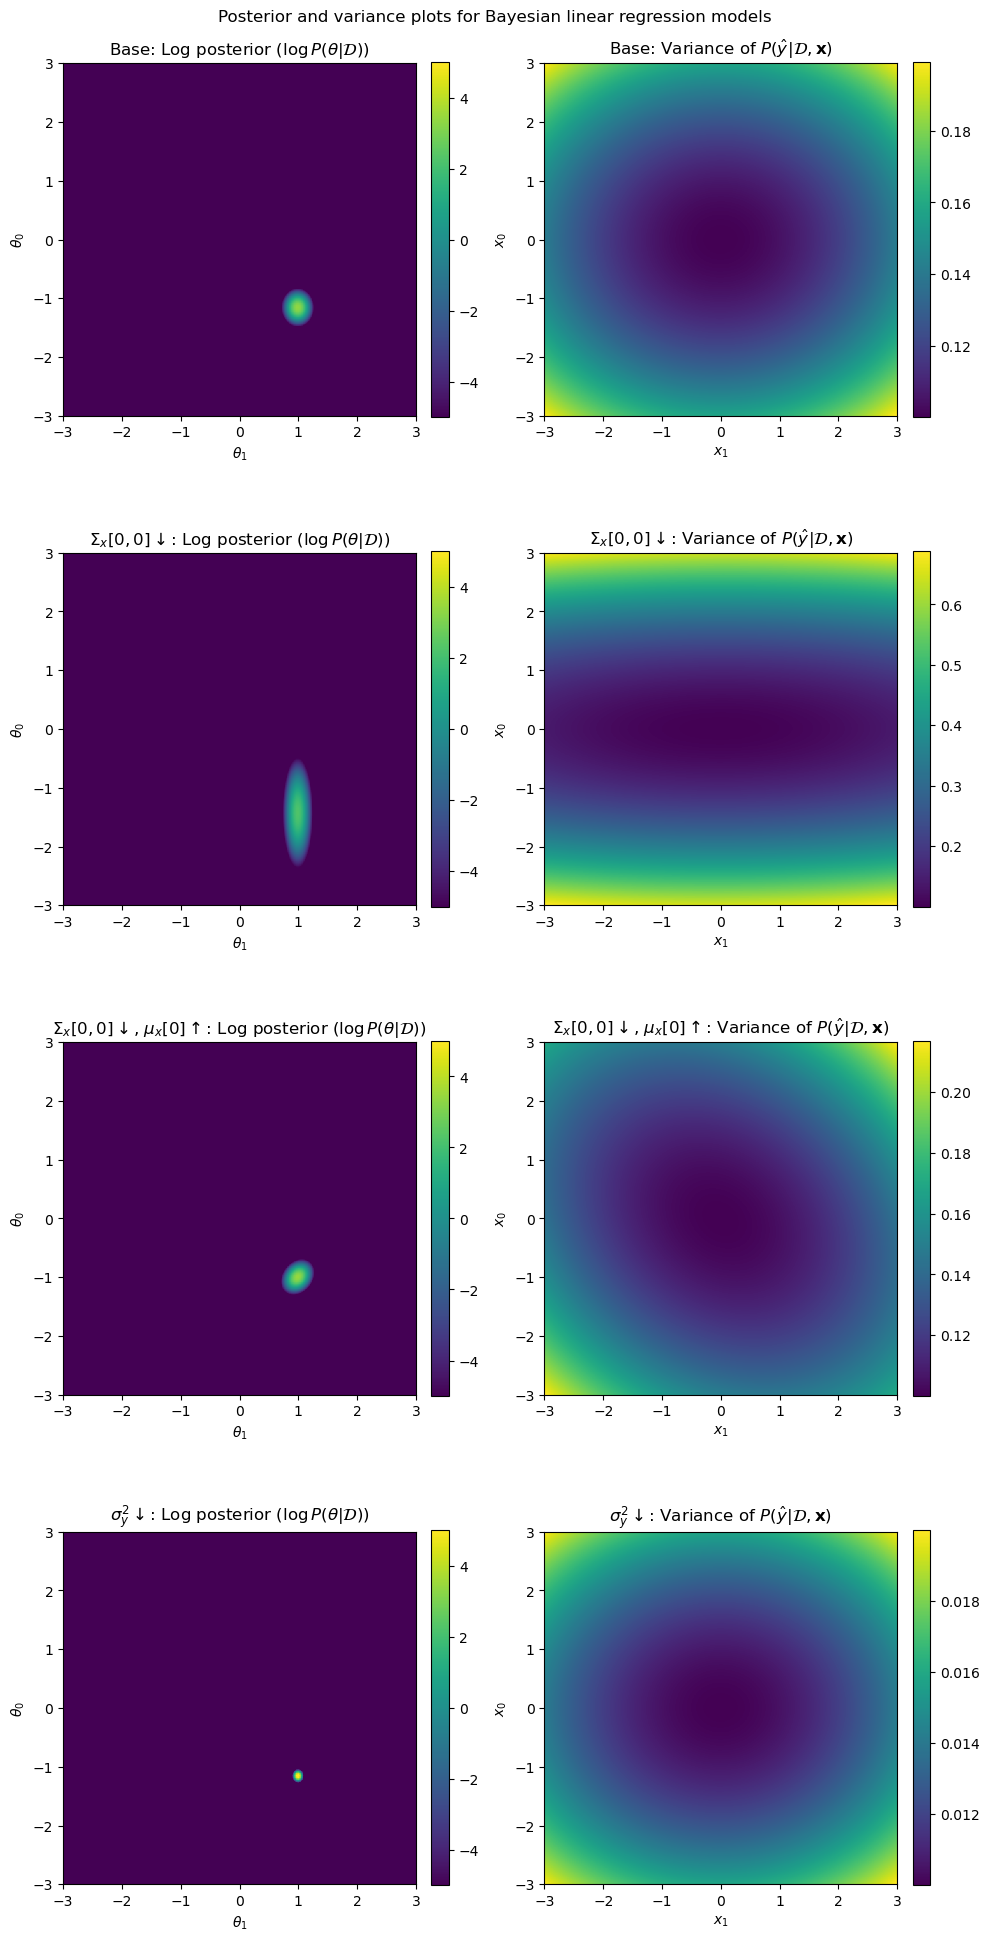

In [14]:
def plot_experiment(
    x_mean: np.ndarray | list,
    x_var_diag: np.ndarray | list,
    target_var: float,
    axs=None,
    seed: int = 42,
    name: str = "",
):
    np.random.seed(seed)
    if axs is None:
        _, axs = plt.subplots(ncols=2, figsize=(10, 5))
    x_vals = custom_multivariate_normal(
        np.repeat(np.atleast_2d(x_mean), 20, axis=0), np.diag(x_var_diag) ** 0.5
    )
    theta = np.array([-1, 1]).reshape((2, 1))
    y_vals = np.vectorize(custom_single_normal)(x_vals @ theta, 0.1)
    post_mean, post_covar = posterior_distribution_params(x_vals, y_vals, target_var)
    plot_param_posterior(post_mean, post_covar, ax=axs[0], extra_title=name)
    plot_pp_var(target_var, post_covar, ax=axs[1], extra_title=name)


_, axss = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
plot_experiment([0, 0], [1, 1], 0.1, axs=axss[0], name="Base")
plot_experiment([0, 0], [0.1, 1], 0.1, axs=axss[1], name=r"$\Sigma_x[0,0]\downarrow$")
plot_experiment(
    [1, 0],
    [0.1, 1],
    0.1,
    axs=axss[2],
    name=r"$\Sigma_x[0,0]\downarrow$, $\mu_x[0]\uparrow$",
)
plot_experiment([0, 0], [1, 1], 0.01, axs=axss[3], name=r"$\sigma^2_y\downarrow$")
plt.suptitle("Posterior and variance plots for Bayesian linear regression models")
plt.tight_layout()

## Comparison

We can see that, compared to the base distribution, reducing the variance of $x_0$ makes the variance for $\theta_0$ increase significantly.
This somewhat counter-intuitive result comes from the fact that the distributions are zero-mean, meaning that if a component has low variance,
then it will have little impact on the target variable: if all the elements of $x_0$ are $\approx 0$, the value for $\theta_0$ has a lower impact
on $y$, making it harder to estimate.
If we use the same lowered variance with a nonzero mean, we see that the parameter posterior variance shrinks significantly (as $x_0$ now always impacts $y$),
and that the posterior becomes diagonal (reflecting that, with the non-zero means, it is possible to trade one variable off for another).

For the posterior predictive variance plots, we see that compared to the base distribution, the version with lower $x_0$ variance shows higher overall variance,
as well as a clear increase in variance when $|x|$ increases. This is because the direction of $\theta_0$ is uncertain, meaning that having larger values of $x$
in this direction will make our prediction less certain. Increasing the mean of $x_0$ again lowers the variance, while also changing the direction of increasing
predictive posterior variance to align with the direction of parameter posterior uncertainty.

Finally, decreasing $\sigma_y^2$ does not change the direction of uncertainty in either of the two plots, but significantly reduces the overall variance:
the primary source of uncertainty in the base version was not in the estimation of $\theta$ but due to the randomness in $y$, so reducing this randomness
greatly reduces the uncertainty of the overall system.